# 2. Literature Review

[index](../Index.ipynb) | [prev](./01.Introduction.ipynb) | [next](./03.SystemDesign.ipynb)

It is important to appreciate and highlight the work of other researchers, without which my concept would never be possible and a project like this could not be delivered by a single person.

This Literature Review will follow the data flow in the process. There are a three main building blocks in this research:
- Data Collection
- Forecasting
- Anomaly Detection

Each of them is very complex and has been studied by scientists for decades.

After two years of my own research and testing, I have narrowed down the list to a handful of useful tools, for which I will provide the theoretical background below.

Before any discussions about Machine Learning models, I would like to point out a fundamental concept, which will be the guide through the rest of my work in this research: **Bias and Variance tradeoff**.

We say that a model is good if it fits the training and testing data well. Models like Linear Regression create a straight line through the data points, and often do not represent the relationships very well. This is called **High Bias**. On the other hand, Learners like Decision Trees model relationships in the training data very well, but tend to perform poorly on the testing sets. We call this behaviour **High Variance**. Ideally we always look for a model with relatively low bias and low variance. In practice, it is a matter of finding a good tradeoff.

Note that the above tradeoff tends to hold for non-Neural Network models, but not necessarily for Neural Networks, which can generalise well, even with their complexity and High Variance (Neal et al., 2018).

## 2.1. Data Collection

The first aspect of my project is the Data Collection phase.

It involves a mini-computer (Raspberry Pi) which streams the data to the central unit (a Ubuntu-based Desktop PC with a GPU), which runs an infinite loop with the two key algorithms:
- Backgroud subtraction
- Yolo Object Recognition

Both of these algorithms are extremelly useful in the image processing applications, and the are the foundation of how data is collected in the system.

They have both significantly reduced the data size, which otherwise would be required to store a six months of video footage.

### 2.1.1. Motion Detection

Let’s consider how can we detect objects of our interest in the video streams.

The naive approach would be to send all 30 frames per second to an object detector script.

This could work, but it would be extremely inefficient from the compute resource utilisation (CPU/GPU/RAM) and speed perspective. Why would we waste the resources to detect objects if there is actually nothing changing in the scene most of the time? Can we somehow detect a significant change in the images (i.e. detect motion) and only if motion is detected use the object detector?

Here is an example of a static background:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.1</p>
<img src="../Resources/img/no-motion.png" style="width: 40%;"/><br>

And here is a moving object (a person running) in a 7 consecutive frames:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.2</p>
<img src="../Resources/img/moving-object.png" style="width: 90%;"/>

It turns out that there is already a set well established algorithms in the Computer Vision domain for that purpose. They are not 100% bulletproof, but they do not need to be. If they can help to reject the 90% of non-interesting frames, we can dedicate the expensive GPU resource to other tasks or simply extend its lifespan. The bonus of not using GPU all the time is that the machine will be much quieter and won’t generate so much heat.

One of the most popular and successful methods for motion detection in images is the **Background Subtraction**.

At a very high level the concept is very simple: we would like to start with a static image without any moving objects. We will call it the **background ($BG$)**. Then, every consecutive frame will be compared against the background to detect any changes in the **foreground ($FG$)**.

Unfortunately, there are many challenges in this optimistic approach. What if:
- the initial background already contains moving objects?
- the next frames actually don’t contain any moving objects, but only light illumination has changed over time?
- shadows started to appear?
- the camera is in-door and we turn the light on and off?
- there are moving tree branches in the background?
- the weather has changed into rain or snow?
- we are not interested in small objects, but only objects of a certain size?

These common anomalies demand a more sophisticated approach than just a simple subtraction of foreground from the background.

One very popular improvement over the vanilla algorithm has been proposed in the *Improved Adaptive Gaussian Mixture Model for Background Subtraction* paper (Zivkivoc 2004). The aim of Zivkivoc’s work was to overcome all the challenges above and achieve efficiency by reducing the processing time.

In the MOG2 model, the background is constantly updated and not static. As author describes it, it uses recursive equations to constantly update parameters and also select appropriate number of components per each pixel. At a high level author describes a metric R (using a Bayesian decision), which follows the formula:

$$
R=\frac{p(BG|\overrightarrow{x}^{(t)})}{p(FG|\overrightarrow{x}^{(t)})}=\frac{p(\overrightarrow{x}^{(t)}|BG)p(BG)}{p(\overrightarrow{x}^{(t)}|FG)p(FG)}
$$

Where the aim is to determine the ratio between the probability of new pixel at time $t$ being a foreground ($FG$) or a background ($BG$).

Since, in general, we don't have any prior information about $FG$, so we set it as a uniform distribution. Then, we decide that object is a $BG$ if the probability of $x$ at time $t$, given $BG$ is greater than some threshold value ($c_{thr}$):

$$
p(\overrightarrow{x}^{(t)}|BG) > (=Rc_{FG})
$$

The left side of the equation is referred to as a background model. It depends on the training set denoted as $X$.

In order to eliminate the problem of suddenly changing lighting factor, authors proposed to keep updating the training set by dropping old values, appending new ones and re-estimating the background model. When we incorporate the fact that within new frames we can have also foreground objects and if we use the Gaussian mixture model with M components, we can update the equation to the following one:

$$
\hat{p}(\overrightarrow{x}|X_T,BG+FG)=\sum^{M}_{m=1}\hat{\pi}_m \mathcal{N}(\overrightarrow{x};\hat{\overrightarrow{\mu}}_m,\hat{\sigma}^2_mI)
$$

Where we are adding means and variances, which describe the Gaussian components. Covariance matrices are
diagonal and identity matrix has proper dimensions. The weights are non-negative and add up to 1.

For each new data samples, equations are updated recursively, as follows:

$$
\hat{\pi}_m \leftarrow \hat{\pi}_m + \alpha(o^{(t)}_m-\hat{\pi}_m)
$$

$$
\hat{\overrightarrow{\mu}}_m \leftarrow \hat{\overrightarrow{\mu}}_m + o^{(t)}_m (\alpha/\hat{\pi}_m)\overrightarrow{\delta}_m
$$

$$
\hat{\sigma}^2_m \leftarrow \hat{\sigma}^2_m + o^{(t)}_m(\alpha/\hat{\pi}_m)(\overrightarrow{\delta}^T_m \overrightarrow{\delta}_m  - \hat{\sigma}^2_m)
$$

We can see an introduction of alpha parameter here, which is exponentially decaying, meaning that the older
data samples will be given less importance:

$$
\alpha=1/T
$$

In the new sample the $o_m^{(t)}$ value is set to $1$ for the component with a largest weight and $0$ in other
components.

The following formula denotes the squared distance from m-th component:

$$
\overrightarrow{\delta}_m^T \overrightarrow{\delta}_m / \hat{\sigma}^2_m
$$

If the maximum number of components is reached, the component with the lowest weight is removed. Hence
the algorithm has been defined by the author to be an "online clustering algorithm".

Author also describes how model deals with foreground objects, which remain static for a longer duration of
time: for the FG object to be considered a BG, it needs to be static for approx. following number of frames:

$$
log(1-c_f)/log(1-\alpha)
$$

$c_f$ stands for the maximum portion of data, which belongs to $FG$ objects without influencing the $BG$ model.
For sample values for $c_f$ and $\alpha$, author has calculated that we would get $105$ frames for the $FG$ object to be
considered a $BG$.

Weights define the underlying multinomial distribution. After additional derivations, author rewrites the first
equation to the following form (this is after including the *Dirichlet* prior for multinomial distribution):

$$
\hat{\pi}_m \leftarrow \hat{\pi}_m + \alpha(o^{(t)}_m-\hat{\pi}_m) - \alpha c_T
$$

Then researcher presented a 3 great examples, where the new algorithm works well with improved performance.

There are pre-requisites for this model to work:
- stationary frame
- image resized (in theory, this is not a strong requirement, but this model is very slow when used with the 1080p or even 720p image resolution)

The OpenCV implementation for Python can be found under `cv2.createBackgroundSubtractorMOG2` function, which I have used to detect motion between consecutive image frames.

The parameters will be explained in the later Chapter: [Data Collection](./04.DataCollection.ipynb).

### 2.1.2. Object Detection

Once motion is detected, resized frames can be sent to an Object Detector to analyse the content of an image.

Object detection comes from two fundamental ideas in Computer Vision:
- Image Classification (look at an image and classify a single class: Car, Person, Dog etc.)
- Object Localization (where an object is located inside an image)

Object Detection's task is to classify multiple objects in an image and tell their locations as well.

Here is an example from a web application, which I have built for my research, which detects motion and object in a real time camera stream:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.3. Real time detection in Web App</p>
<img src="../Resources/img/person-detected.png" style="width: 50%;"/>

In *Fig. 2.3* there is a person walking by in front of the parking area. There is a box around the person, called the *bounding box*. If there was more people in the frame, they would be all highlighted as well.

This is an evolving field with new algorithms and applications been developed at high frequency. This is an advantage, as it creates new opportunities, but it's also a challenge for practicioners to keep up with the fast pace of change.

Out of two arguably most popular options for object detection in Python: **Yolo** and **SSD**, I have decided to use Yolo (You Only Look Once) due to the fact that it can be run in real time on a GPU at 30+ frames per second with good documentation and wide-spread adoption rate. I have not found a GPU implementation for the SSD (Single Shot Detector) algorithm.

#### Yolo V1:

Even though in my research I have used Yolo Version 2, the section below is dedicated to Yolo version 1, as it is the foundation for object detection, which utilises multiple Computer Vision and Deep Learning paradims.

Yolo v1 (Redmon et al., 2015) has been released in 2015 as a new approach to object detection, which promised extreme speed and making real time object detection a reality. This was a significant achievement in comparison to previous object detectors, like R-CNN (Girshick et al. 2013) where a single image could take 20 seconds to get processed or even in comparison to more modern Fast R-CNN (Girshick 2015), which still took 2 seconds to process a single image and Faster R-CNN (Ren et al., 2015) with 0.14 second per frame.

The processing time can be extremely important for certain applications, like self driving car or camera monitoring system and, according to the authors, Yolo can run at 45 frames per second with a slight decrease in accuracy for smaller objects.

To visualize this progress, I have put in into a table below:

| Detector      | FPS |
| ------------- | --- |
| R-CNN | 0.05 |
| Fast R-CNN  | 0.5 |
| Faster R-CNN | 7 |
| Yolo v1 | 45 |

Yolo owes this gain in speed to a complete re-think of how the object detectors can operate. Instead of using a traditional approach, like:
- sliding window with HOG (Histogram of Oriented Gradients) and SVM (Support Vertor Machine)
- region proposals (seen in R-CNN's)

, Yolo uses a single pass through the entire image to generate predictions (with sliding window it might be hundreds or thousands passes through an image of a different size),

Then to get rid of overlapping bounding boxes, the boxes with very low propability are discarded, and Non-max supression algorithm is applied.

This approach then leaves us with an output of 1470 feaures, containing all the data we need to understand the content of an image. Assuming that we are trying to predict any of 20 object classes, the calculation is as follows:

$$
7x7x(2x5+20) = 7x7x30tensor = 1470features
$$

, where $7x7$ is related to a grid size, which image is divided by, $2x5$ means we will have 2 bounding boxes inside each grid cell, and $20$ is a number of predicted classes in a One Hot Encoded notation.

Each grid cell predicts two boxes and can only have a single class.

Below is the name and description for each of the 5 nodes found in each bounding box:
- Conf - confidence
- x - x coordinate of center of the box (relative to grid cell)
- y - y coordinate
- w - width of the box (relative to whole image)
- h - height

The confidence if object is present is calculated as:
$Pr(Object)*IOU^{truth}_{pred}$

, where $IOU$ represents an Intersection Over Union, an evaluation metric for bounding boxes:

$$
IOU=\frac{areaOfOverlap}{areaOfUnion}
$$

If there is no object present in the cell, then the confidence will be Zero, but if there is an object, it will equal to the $IOU$ metric.

For training, a following Convolutional Neural network is used:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.4. Yolo v1 architecture</p>
<img src="../Resources/img/yolo-v1-architecture.png" style="width: 75%;"/>

, with 24 convolutional layers followed by 2 fully connected layers. Convolutional layers are pretrained on ImageNet classification (with 1000 classes), and final output is, as expected, a $7x7x30$ tensor.

This type of a complex network was trained for a week using the *Darknet* framework, which I have used for the real time inference in my research.

The network is trained with $224x244$ image resolution and then extended to $444x448$ at detection stage.

As activation function, authors have used a leaky rectified linear activation:

$$
\begin{equation}
  f(x)=\begin{cases}
    x, & \text{if $x>0$}\\
    0.1x, & \text{otherwise}
  \end{cases}
\end{equation}
$$

The loss function to optimise is the highly customised $SumSquared Error$ with the specific characteristics:
- to avoid issues with gradients for cells without any objects
- to distinguish errors in large boxes versus small boxes (errors in large boxes matter less)

Here are other significant training parameters:
- epochs: $135$
- batch size: $64$
- momentum: $0.9$
- decay: $0.0005$
- custom learning rate schedule

To prevent the overfit, dropout layers are introduced, and to increase image variability data augmentation is used.

Overall, Yolo is a good tradeoff between speed and accuracy and at present is one of the most useful frameworks, which can be used free of cost with high level of available documentation and examples.

#### Yolo V2:

An upgraded version of Yolo (V2) was released in 2016 as a state of the art real time object detector capable of detecting over 9000 object categories.

Capable of achieving a 76.8 mAP (mean average precision) on VOC 2007 (The PASCAL Visual Object Classes Challenge 2007) while maintaining 40 FPS (frames per second), which, as authors conclude, outperforms the other two most populate object detectors: *SSD* and *Faster RCNN with ResNet*.

The main improvements in Yolo v2 have been achieved throgh a number of core ideas:
- Batch Normalization: Added to all convolutional layers to stabilize training, speed up convergence and add regularisation
- High Resolution Clasifier: End to end fully trained on $448x448$ image resolution, so more details can be detected
- Convolutional With Anchor Boxes: Diving an image into N-overlapping boxes of WxH size - helpful to detect smaller objects, like multiple people faces
- Dimension Clusters: Instead of hand picked anchor box dimensions, Yolo V2 uses k-means clustering with a custom distance metric $d(box,centroid)=1-IOU(box,centroid)$
- Direct location prediction: Increase model stablity during early training iterations by introducing logistic activation to constrain network predictions or coordinates relative to the location of the cell grid
- Multi-Scale Training: Aim is to make the model robust to varied image resolutions, which is achieved by randomly choosing a new image dimension every 10 batches during the training (size must be divisible by 32, from $320x320$ to $608x608$. When Yolo is run at $288x288$ it achieves much better performance, which might be useful for multiple video streams (for example one camera inside and two outside the house)

The architecture is composed of 19 convolutional layers and 5 maxpolling layers. To process an image 5.58 billion operations is required. This might seem very high, but it is much lower in comparison to a very popular choice for feature extractor VGG-16 (Simonyan et al. 2014), which require 30.69 billion floating point operations. Yolo V1 required 8.52 billion, as it was based on the Googlenet architecture (Shegedy et al. 2014).

Yolo V2 uses its own classification model called **Darknet-19**, which is trained for classification and for detection using slightly different architecture and hyper-parameters and similar data augmentation techniques.

The *classification model* uses ImageNet dataset with 1000 very fine-grained classes (like "Norfolk terrier") and *detection model* uses COCO dataset with 80 high-level class names (like "dog").

Since authors wanted to jointly train on classification and detection data, a **hierarchical classification** was used, where the final softmax layer with the flat encoding of mutually exclusive labels is not assumed. This has been achieved using an approach borrowed from Natural Language Processing called WordTree, where for each detail class a probability is calculated if this class belongs to a broader category, example:

$$
Pr(Norfolk terrier|terrier)
$$

This model has been visualized as follows:

<p style="text-align: center; margin-bottom: 5px;">Fig. 2.5. Yolo V2 WordTree</p>
<img src="../Resources/img/word-tree.png" style="width: 45%;"/>

#### Yolo V3, V4:

Since 2016 and now, there have been already two new papers produced for the Yolo object detector:

version 3 (Redmon et al. 2018)
version 4 (Bochkovskiy et al. 2020)
They both look very promising in terms of further accuracy increase with many tweaks and modern improvements, but I leave this work for the future increments of this project.

### 2.1.3. Conclusion

Yolo V2 represents a good trade off between accuracy and performance, and has proven to work well in case of detecting people and vehicles from the Raspberry Pi camera frames, which I discuss further in the [Data Collection](./04.DataCollection.ipynb) chapter.

## 2.2. Forecasting

The next theme of this project is Forecasting. 

One of the research questions is if Machine Learning can improve the performance of the naive baseline, which predicts Object Counts based on the hourly averages calculated from the historical data.

In my work I have utilised one naive and two Machine Learning algorithms, which are described below:
- Gradient Boosting Decision Tree
- Gaussian Process

I have also tried many other algorithms, like:
- Linear Regression
- Feed Forward Neural Network
- Long Short Term Memory Recurrent Neural Network

The additional algorithms were not beneficial to my results due to the following reasons:
- they are not designed to model non-linear relationships (Linear Regression)
- they are more relevant for much larger datasets (Neural Networks overfitted very quickly and added computational overhead)
- they either don't have a good implementation for the Count Data

### 2.2.1. Gradient Boosting Decison Tree

#### Decision Tree Regressor

**Decision Trees** are a building block for many more sophisticated Machine Learning algorithms. Their simplicity and interpretability make them a very popular choice, when decisions must be clearly understood and explained.

The history of Decision Trees used for regression problems is not very easy to track, and goes back to a research by J.N. Morgan (Morgan et al., 1963, p. 430) titled *Problems in the Analysis of Survey Data, and a Proposal*, where arguably first decision tree for regression is drawn. What has been a challenge back then (computational overhead) is actually not an issue in 2020, which makes Decision Trees one of the fastest Machine Learners available for relatively condensed datasets.

The problem with decision trees is their low accuracy on an out-of-sample datasets and low robustness (small changes in training data may easily lead to a very different tree). It is however important to discuss their inner workings before moving on to the more advanced algorithms.

Here is an example output from a Tree Regressor algorithm run on a small subset of $100$ observations (for ilustrative purpose) from the dataset with people detections:

<p style="text-align: center; margin-bottom: 5px;">Fig. 2.6. Decision Tree</p>
<img src="../Resources/img/tree.png" style="width: 55%;"/>

This tree can be interpreted as a series of sub-decisions to reach a goal. Following the **right hand side path**, the model predicts a value of $2.875$ by making the following decisions:
- `uvIndex` is greater than $0.5$
- `temperature` is greater than $2.99$
- `hour` is greater than $10$

It intuitively makes sense, as during the day, when temperature is not very low and after 10AM, we can expect approximately $3$ objects.

Basic terminology related to the hierarchy above:
- the single box on top of the diagram is called a **root node**
- nodes in the middle are called the **decision nodes** and are connected by arrows creating a section called a **branch**
- the eight boxes in the bottom are **leaf nodes**

The best split for Regression Trees is usually calculated using a **mean squared error**, however other metrics (like a mean absolute error) can be utilised as well.

The top-down procedure to generate a tree is the same for each node:
- iterate through candidate features
- for each feature:
    - sort values
    - find average between each pair of values and use as a candidate split value
    - calculate average for values the left and right nodes
    - calculate squared residuals for each node
    - sum all residucals or average those
- split the data by the feature and value, which produces the lowest squared error
- keep doing this until:
    - reached maximum depth of a tree allowed
    - there is not enough samples to create a split
    - all samples contain the same value
- leaf nodes will eventually contain an average value for the target variable

Hyperparameters `max_depth` and `min_samples_split` are used as a regularization term to avoid creating a model with too high variance.

#### Gradient Boosting Regressor Tree

There are many extensions to the base Decision Tree algorithm. I have found the Gradient Boosting Regressor to work the best with the object detections dataset and below is a brief description of the inner workings of this algorithm.

The **Histogram Based Gradient Boosting Regressor** is a relatively new estimator added in 2019 into the Sci-Kit Learn library, developed in `Cython` to optimise speed, and it is promoted as being very efficient and capable of handling large datasets and missing values.

The implementation in sklearn was inspired by the 2017 paper by Guolin Ke et al. (Ke et al., 2017): LightGBM: A Highly Efficient Gradient Boosting Decision Tree and it is a modern take on the original Gradient Boosting Machine algorithm by Jerome Friedman (Friedman, 1999).

The original algorithm developed by Friedman puts robustness as one of the most favorable characteristics. The paper also mentions that the TreeBoost removes the need for feature transformations, and chooses only important features, while ignoring irrelevant input variables. It handles missing data, and enhances stabilty through the use of many small trees (instead of a single large one). Author admits that single Decision Tree is easier to interpret than many (even hundreds) small trees, however when one tree grows to a very large scale, this conclusion does not hold any more.

Below is the high level algorithm, which is a workhorse for the Gradient Boost:

- Firstly we need to have a dataset consisting of input features and a target variable $\{(x_j, y_i)\}^n_{i=1}$ and a Loss Function, which is differentiable $L(y,F(x))$ (like least squares)
- Then we initialize a model with a constant value: $F_0(x)=argmin_{\gamma} \sum^n_{i=1}L(y_i,\gamma)$, we can easily solve this equation and find the initial predictions by taking the derivatives for the losses for each target, summing them up and setting the sum to $0$. In the Decision Tree terminology, this step creates a leaf, which predicts the initial values
- Next section is an iteration for $m=1$ to $M$ which produces $M$ small trees (where $M$ is a hyperparameter to tune), and contains following steps
    - Compute $r_{im} = -[\frac{\partial L(y_i,F(x_i))}{\partial F(x_i)}]_{F(x}=F_{m-1}(x)$ for $i=1,...,n$
    - Fit regression tree to the $r_{im}$ values and create terminal regions $R_{jm}$ for $j=1...J_m$
    - For $j=1,...,J_m$ compute $\gamma_{jm}=argmin_{\gamma} \sum_{x_i \in R_{ij}} L(y_j,F_{m-1}(x_i)+\gamma)$
    - Update $F_m(x)=F_{m-1}(x)+\nu \sum^{J_m}_{j=1}\gamma_m I(x \in R_{jm})$, where $\nu$ is another hyperparameter to tune, the learning rate
- The iteration stops when either all steps were exhausted or when there is no significant change in the errors

The key idea in the *Histogram Based Gradient Boosting* is related to the way Decision Trees find the best value to split the data. As discussed previously, a Decision Tree normally sorts the values and then for each pair of values they run a test if the split is optimal.

This obviously creates a computational problem for larger datasets, so the authors had an idea to bin the values into (typically) 256 bins and use integer-based data structures (histograms). This way they avoided expensive sorting and then testing for all continous, floating point values.

One of the most recent improvements in this algorithm in `sklearn` is a **Poisson** loss function, which is more suitable for the count data and when data is believed to come from a Possion distibution. 

$$
L(y,\hat{y})=\frac{1}{N}\sum^N_{i=0}(\hat{y}_i-y_ilog\hat{y}_i)
$$

where $\hat{y}$ is the predicted expected value and $y$ is the ground truth value.

Minimising the Poisson loss is equivalent of maximizing the likelihood of the data under the assumption that the target comes from a Poisson distribution, conditioned on the input ([peltarion.com, Poisson loss](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/poisson)).

This is a loss function, which is used in the [Forecasting Notebook](./05.Forecasting.ipynb).

### 2.2.2. Gaussian Process

Gaussian Distribution, also known as Normal Distribution is the cornerstone of statistical learning.

Whether we associate the origins of the theory with Abrhama de Moivre (1667-1754) or Carl Friedrich Gauss (1777-1855), it is a fundemendal concept used to model real-valued, random and continuous variables, which can be observed vastly in the nature, social studies, mathematics and engineering.

The Central Limit Theorem (Laplace 1810) and unique analytical properties make Gaussian distributions a very useful tool, which can be also applied to Machine Learning.

The literature review below takes a gradual approach in order to understand the Gaussian Processes ([peterroelants blog](peterroelants.github.io)):
- Univariate Gaussian Distribution
- Multivariate Gaussian Distribution
- Gaussian Process

#### Univariate Gaussian

Gaussian distribution is given by:$\mathcal{N}(\mu, \sigma^2)$, where $\mu$ is the expected value of a distribution, and $\sigma$ corresponds to a standard deviation from $\mu$. Sigma squared ($\sigma^2$) is also known as a variance.

The $pdf$ (probability density function) for a normal distribution is given by:

$$
p(x|\mu,\sigma)=\frac{1}{\sqrt{2\pi \sigma^2}}exp(-\frac{(x-\mu)^2}{2\sigma^2})
$$

The word "univariate" relates to a single random variable ($x$) in the equation above. Using it, we can plot several values for $\mu$ and $\sigma$ and observe a familiar, "bell curve" shaped plots:

In [55]:
%run ../Notebooks-Generic/ConfigImports.ipynb

def uni_normal(x, mean, sigma):
    """Use equation above to generate probability for points above"""
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mean)**2/(2*sigma**2))

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


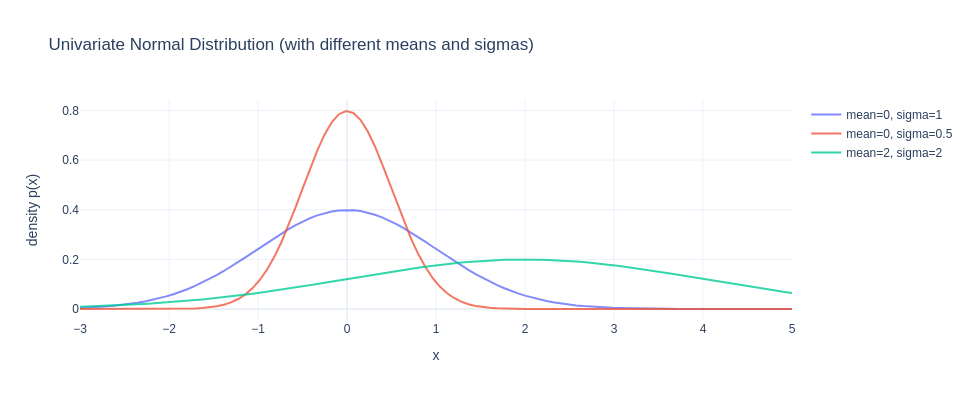

In [57]:
# use Gaussian to generate probabilities for a set of points
x = np.linspace(-3, 5, 100)
y1 = uni_normal(x, 0, 1)
y2 = uni_normal(x, 0, 0.5)
y3 = uni_normal(x, 2, 2)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y1, mode='lines', name='mean=0, sigma=1', opacity=0.8))
fig.add_trace(go.Scatter(x=x, y=y2, mode='lines', name='mean=0, sigma=0.5', opacity=0.8))
fig.add_trace(go.Scatter(x=x, y=y3, mode='lines', name='mean=2, sigma=2', opacity=0.8))
fig.update_layout(autosize=False, width=650, height=400,
    xaxis_title="x", yaxis_title="density p(x)",
    title='Univariate Normal Distribution (with different means and sigmas)')
fig.show()

#### Multivariate Gaussian

Multivariate normal distribution is used for analysis of mutliple random variables (for example $x_1$ and $x_2$). Similarly to the univariate case, it is defined by a two parameters:
- mean vector $\mu$
- covariance matrix $\Sigma$, which measures how correlated each pair of variables is

The quation below describes a join probability for the multivariate normal with $d$ variables (i.e. the dimension of the dataset):

$$
p(x|\mu,\Sigma)=\frac{1}{\sqrt{(2\pi)^2|\Sigma|}}exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu))
$$

, where $x$ is this time a vector of values (of size $d$), $\Sigma$ is the symmetric and positive definite covariance matrix (of size $dxd$), and $|\Sigma|$ is its determinant.

As a shorthand, we use $\mathcal{N}(\mu, \Sigma)$ to denote this distribution.

Below are a two examples of multivariate Gaussian distribution:
- first example shows 2 uncorrelated variables. Change in $x_1$ does not mean a change in $x_2$ ($0, 0$ diagonals in $\Sigma$):

$$
\mathcal{N}\left(\begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

- second example shows 2 highly correlated variables. When $x_1$ increases, $x_2$ will increase also ($0.9, 0.9$ diagonals in $\Sigma$):

$$
\mathcal{N}\left(\begin{bmatrix} 1 \\ 2 \end{bmatrix}, \begin{bmatrix} 1 & 0.9 \\ 0.9 & 1 \end{bmatrix}\right)
$$

In [58]:
def multi_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

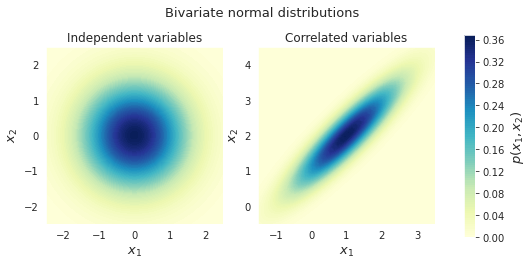

In [78]:
# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multi_normal(np.matrix([[x1[i,j]], [x2[i,j]]]), d, mean, covariance)
    return x1, x2, pdf

# Import colormaps
from matplotlib import cm

# subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
d = 2  # number of dimensions

# Plot of independent Normals
bivariate_mean = np.matrix([[0.], [0.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.], 
    [0., 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.set_aspect('equal')
ax1.set_title('Independent variables', fontsize=12)

# Plot of correlated Normals
bivariate_mean = np.matrix([[1.], [2.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.9], 
    [0.9, 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax2.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([-1.5, 3.5, -0.5, 4.5])
ax2.set_aspect('equal')
ax2.set_title('Correlated variables', fontsize=12)

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('Bivariate normal distributions', fontsize=13, y=0.95)
plt.show()

Sampling from a multivariate distribution can be done by sampling from the standard normal $X~\mathcal{N}(0, I_d)$, where $\mu=0$ and covariance is the identity matrix $I_d$.

Then we apply an *affine transformation* to $X$, where $Y=LX+\mu$ and covariance $\Sigma_y=LL^T$ (we can ommit the $\Sigma$ from the affine transform, as it is an identity matrix.

The next step is to find $L$ and this is done using a technique called the **Cholesky decomposition** (Cholesky 1910)  used for efficient numerical solutions.

A pseudo-code below can be used to sample from the Correlated examples above:

```python
mean, covariance = np.matrix([[1.], [2.]]), np.matrix([[1, 0.8], [0.8, 1]]) # Define mean and covariance
L = np.linalg.cholesky(covariance) # Apply Cholesky to find L
X = np.random.normal(size=(50, 2)) # Sample X from standard normal
Y = L.dot(X) + mean # Apply the transformation
```

The conditional distribution for $x$ given $y$ is defined as $p(x|y)=\mathcal{N}(\mu_{x|y}, \Sigma_{x|y})$, with:

$$
\mu_{x|y}=\mu_x+CB^{-1}(y-\mu_y)
$$

$$
\Sigma_{x|y}=A-CB^{-1}C^T=\tilde{A}^{-1}
$$

, with the symbols explained below:

$$
\begin{bmatrix} x \\ y \end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix} \mu_x \\ \mu_y \end{bmatrix}, \begin{bmatrix} A & C \\ C^T & B\end{bmatrix}\right) = \mathcal{N}(\mu, \Sigma)
$$

Pseudo-code to find means and covariances is now simple and can be found below:

- Calculate $x|y$:

```python
y_condition = 1.  # To condition on y
mean_xgiveny = mean_x + (C * (1/B) * (y_condition - mean_y))
cov_xgiveny = A - C * (1/B) * C
```

- Calculate $y|x$

```python
x_condition = -1.  # To condition on x
mean_ygivenx = mean_y + (C * (1/A) * (x_condition - mean_x))
cov_ygivenx = B - (C * (1/A) * C)
```

#### Gaussian Process

Gaussian process is a stochastic process ([Wikipedia, 2020](https://en.wikipedia.org/wiki/Gaussian_process)) involving random variables, represented by a miltivariate normal distribution. It is a joint distribution over inifitely many random variables, and as such, it is a distribution over functions $f(x)$ with a continous domain.

When used in the Machine Learning context, a concept of kernel function (measuring similarity between points) is used to predict values for unseen data points.

A practical benefit from such an approach is that the result is not only a point estimate, but also a range of standard deviations, which can be interpreted as an uncertainty.

The difference between the multivariate Gaussian and Gaussian process is that Gaussian processes operate on $mu$ and $\Sigma$ defined as a function, which removes the limitation of the finite number of jointly distributed Gaussians.

Gaussian process is defined as:

$$
f(x) \sim \mathcal{GP}(m(x), k(x,x'))
$$

, where $m(x)$ is a mean function and $k(x,x')$ is a covariance function.

In the Bayesian language, selecting the specification for the covariance function (called the kernel function), is setting a prior information. Kernel again needs to be positive-definite to be a valid function.

The most popular kernel function is the exponential quadratic (RBF kernel), which produces a smooth function, and this is in fact the function used in this research. It is given by:

$$
k(x_a, x_b)=exp(-\frac{1}{2\sigma^2}\|x_a-x_b\|^2)
$$

We can sample from prior using a finite number of points. This results in a marginal distibution that is Gaussian.

In [84]:
from scipy.spatial.distance import cdist
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [95]:
# Sample from the Gaussian process distribution
nb_of_samples = 150  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
kernel = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=kernel, 
    size=number_of_functions)

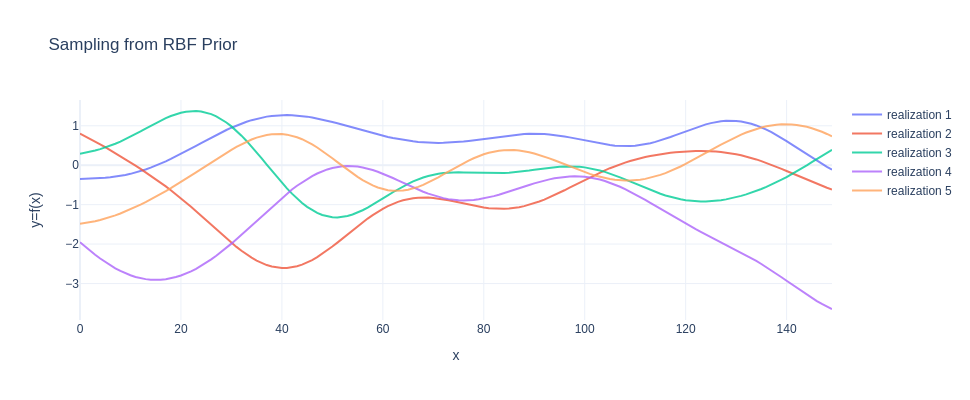

In [96]:
fig = go.Figure()
for i,y in enumerate(ys):
    fig.add_trace(go.Scatter(y=y, mode='lines', name=f'realization {i+1}', opacity=0.8))
fig.update_layout(autosize=False, width=650, height=400,
    xaxis_title="x", yaxis_title="y=f(x)", title='Sampling from RBF Prior')
fig.show()

**Using Gaussian Process for regression** is a three step process:

1. Define a prior kernel function
2. Create posterior distribution, given some data
3. Generate predictions ($y$) for the input variables ($X$)

To make predictions $y_2=f(X_2)$, we can draw samples from the posterior distribution $p(y_2|y_1,X_1,X_2)$:

$$
\begin{bmatrix} y_1 \\ y_2 \end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}, \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix}\right)
$$

and we can use the conditional distribution:

$$
\mu_{2|1}=(\Sigma^{-1}_{11} \Sigma_{12})^T y_1
$$

$$
\Sigma_{2|1}=\Sigma_{22}-(\Sigma^{-1}_{12} \Sigma_{12})^T \Sigma_{12}
$$

And so $y_2$ can be predicted by using mean $\mu_{2|1}$.

The visualization for predictions for a noiseless distribution shows that uncertainty (a salmon-color fill around the sine wave) in the points with data (black dots below) is minimal, but it grows in the sections without any data points:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.4. Gaussian Process predictions and uncertainty</p>
<img src="../Resources/img/gp.png" style="width: 60%;"/>

### 2.2.3. Conclusion

Gaussian processes are a very elegant, robust and informed approach to Machine Learning. One not only generates predictions for unseen data, but also the uncertainty. This can be a very useful tool in the decision making.

However it is important to keep in mind that working with larger datasets can be a **challenge** due to $\mathcal{O}(n^3)$ complexity. In my eyes, certainly Gaussian process algorithms were very slow to train (given that I have only used them with $< 4000$ records) and they have consumed a lot of memory (GPy was much more efficient than pymc3).

There are tricks used to decrease the complexity to $\mathcal{O}(n^2)$ and new frameworks continously work on the improvements (pymc3 library is currently switching backend to TensorFlow), but training Gaussian Process-based models can be a challenging and time consuming task.

## 2.3. Autoencoders for Anomaly Detection

The core idea of the system in my research is Anomaly Detection. It could very useful to alert home owners when something out of the ordrinary is happening around their property.

Below is a Literature Review on **Autoencoders**, which are a very useful Neural Network models often used for anomaly detection in large datasets (like image or text data).

Autoencoder is a type of a Neural Network used to learn to predict (reconstruct) its own inputs. Based on this aspect it is loosely classified as an unsupervised learning algorithm.

There seems to be no definitive evidence of the origins for this Neural Network architecture, but it is described in detail in an online [DeepLearning book](http://www.deeplearningbook.org/contents/autoencoders.html) (Goodfellow-et-al-2016), where author dates the method back all the way to 80's, even though the terminology and use cases have changed drastically over the years.

In the modern are, autoencoders are used to achieve several goals, like:
- data compression (dimensionality reduction)
- image de-noising
- anomaly detection
- machine translation

While there are several variants of this type of Neural Network, at a high level it can be represented in a following diagram from [towardsdatascience 2017](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798) article:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.5. Autoencoder diagram</p>
<img src="../Resources/img/ae.png" style="width: 50%;"/>

If the Encoder part is $h=f(x)$, then the Decoder is $r=g(h)$.

The main idea behind this design is to use a Feed-Forward Network to learn to copy the Input, but due to the size-constrained bottleneck layer in the middle, only the most salient characteristics of the data are learned (an autoencoder, which can learn to reproduce the inputs perfectly would not be very useful).

The learning process is fairly standard and aims to minimize a loss function:

$$
\mathcal{L}(x, g(f(x)))
$$

, where $\mathcal{L}$ can be any differentiable function like *mean squared error*, penalising $g(f(x))$ from being dissimar from $x$.

When MSE is used, autoencoder can be compared to PCA, but with a non-linear choice for functions $f$ and $g$, it becomes a more powerful non-linear generalization of PCA.

There are tradeoffs to such a powerful model. As authors of the DeepLearning book conclude, when this model is given too much capacity, it fails to learn anything useful.

Given this challenge, a whole family of autoencoder type of models have been developed, with **Variational Autoencoders** being the most popular one.

#### TODO: Consider including a section about Variational Autoencoders (if time permits)

## 2.4. Conclusion

Autoencoders conclude the Literature Review in this research. The knowledge base in the area of object detection, forecasting and anomaly detection is vast with new research papers and articles landing every day, but I hope that the overview above sets the tone on what is to come in the next chapters.

And the next Chapter focuses on the overall **System Design**.

[index](../Index.ipynb) | [prev](./01.Introduction.ipynb) | [next](./03.SystemDesign.ipynb)